# **CSCI6515 Project** 

**Group members :**
1. Amirul Sunesara - B00813456
2. Surabhi Chaudhary - B00826371 

In [0]:
#importing libaries
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import warnings
import os
import glob
import cv2
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from keras.layers import Dropout, Dense,Input,Embedding,Flatten, MaxPooling1D, Conv1D,UpSampling1D
from keras.models import Sequential,Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import Concatenate
from keras.layers.core import Reshape

warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
#initiliaze list to store all news data from xml file
listNews = []
#iterate over all xml files in 'Data' directory and store all fields in list
for file in os.listdir('Data'):
    if not file.endswith('.xml'): 
        continue
    fileData = os.path.join('Data', file)
    tree = et.parse(fileData)
    root = tree.getroot()
    row = {}
    row["XMLfilename"] = file.split('.')[0]
    row["itemid"] = root.attrib.get('itemid')
    row["date"] = root.attrib.get('date')
    
    news = ''
    for i in root.find('text').iter('p'):
        news += i.text
    
    row["text"] = news
    row["title"] = root.find('title').text
    row["headline"] = root.find('headline').text
    if(root.find('byline') is not None):
        row["byline"] =  root.find('byline').text
    else:
        row["byline"] = np.NaN 
    if(root.find('dateline') is not None):
        row["dateline"] =  root.find('dateline').text
    else:
        row["dateline"] = np.NaN 
    row["copyright"] = root.find('copyright').text

    for node in root.iter('dc'): 
        colname = node.attrib.get('element')
        colvalue = node.attrib.get('value')
        row[colname] = colvalue
    
    #insert labels
    for code in root.iter('codes'):
        arrBip = code.attrib.get('class').split(':')
        codes_class = arrBip[0]+':'+arrBip[1]
        if(codes_class!='bip:topics'):
            row[codes_class] = code.find('code').attrib.get('code')
    
    for code in root.iter('codes'):
        arrBip = code.attrib.get('class').split(':')
        codes_class = arrBip[0]+':'+arrBip[1]
        if(codes_class=='bip:topics'):
            for c in code.iter('code'):
                rowCopy = row.copy()
                rowCopy[codes_class] = c.attrib.get('code')
                listNews.append(rowCopy)


In [0]:
#convert list to dataframe
df = pd.DataFrame(listNews)

In [0]:
#functions to pre-process the text data, training classifiers
def filter_df(df):
    return df[["headline","text","bip:topics","itemid","dc.date.published","XMLfilename"]]

def getLabels(df):
    return df["bip:topics"]

def prepare_text_data(df):
    stop_words=set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    index=0
    for i, row in df.iterrows():
        text = row['text']
        #remove numbers and non letter characters
        text = re.sub(r"[^a-zA-Z]+", ' ',text)
        #convert text to lower case
        text = text.lower() 
        #remove stop words
        text = ' '.join([word for word in text.split() if word not in stop_words])
        #lematize words
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
        df.loc[i,'text'] = text
        index=index+1
    return df

def generate_features_and_labels(df):
    newDf=pd.DataFrame()
    newDf["labels"] = getLabels(df)
    newDf["features"] = df["text"]
    newDf = newDf.dropna()
    tfidf_vectorizer = TfidfVectorizer()
    features = tfidf_vectorizer.fit_transform(newDf["features"])
    #svd = TruncatedSVD(2)
    #transformed = svd.fit_transform(features)
    return newDf,features

def train_classfier(modelName,df):
    print("----"+modelName+"----")
    newDf,features = generate_features_and_labels(df)
    labels = newDf["labels"]
    print("feature size",features.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.3,random_state=42)
    if modelName == 'Random Forest':
        clf_rf = RandomForestClassifier()
        clf_rf.fit(X_train, y_train)
        pred = clf_rf.predict(X_test)
        cross_validation = cross_val_score(clf_rf,features,labels,cv=5)
        print("cross-validation score: " +str(cross_validation.mean()))
    elif modelName == 'Decision Tree':
        grid_param={'min_samples_split' : [10,50,100],'max_depth': [2,4,8]}
        clf_dt = GridSearchCV(DecisionTreeClassifier(),param_grid=grid_param,cv=5,n_jobs=-1)
        clf_dt.fit(X_train,y_train)
        pred = clf_dt.predict(X_test)
        cross_validation = cross_val_score(clf_dt,features,labels,cv=5)
        print("cross-validation score: " +str(cross_validation.mean()))
    elif modelName == 'Gradient Boost':
        #grid_param={'n_estimators':[100,200,300],'min_samples_split':[2,4,6]}
        #clf_gb = GridSearchCV(GradientBoostingClassifier(),param_grid=grid_param,cv=5,n_jobs=-1)
        clf_gb = GradientBoostingClassifier()
        clf_gb.fit(X_train,y_train)
        pred = clf_gb.predict(X_test)
        cross_validation = cross_val_score(clf_gb,features,labels,cv=5)
        print("cross-validation score: " +str(cross_validation.mean()))
    elif modelName == 'Neural Network':
        grid_param={'alpha': [0.0001,0.03],'learning_rate': ['constant','adaptive']}
        clf_nn = GridSearchCV(MLPClassifier(),param_grid=grid_param,cv=5,n_jobs=-1)
        clf_nn.fit(X_train,y_train)
        pred = clf_nn.predict(X_test)
        cross_validation = cross_val_score(clf_nn,features,labels,cv=5)
        print("cross-validation score: " +str(cross_validation.mean()))
    elif modelName == 'SVM':
        clf_svm = SVC(kernel='linear')
        clf_svm.fit(X_train, y_train)
        pred = clf_svm.predict(X_test)
        cross_validation = cross_val_score(clf_svm,features,labels,cv=5)
        print("cross-validation score: " +str(cross_validation.mean()))
    
    return y_test,pred

def evaluate_classfier_quality(pred,y_test):
    accuracy = metrics.accuracy_score(y_test,pred)
    print("Accuracy: %1.4f" %accuracy)
    precision = metrics.precision_score(y_test,pred,average='weighted')
    print("Precision: %1.4f" % precision)
    recall = metrics.recall_score(y_test,pred,average='weighted')
    print("Recall: %1.4f" % recall)
    f1 = metrics.f1_score(y_test,pred,average='weighted')
    print("F1: %1.4f" % f1)
    return accuracy,precision,recall,f1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#calling the function to pre-process the data and saving it to a csv file
df = filter_df(df)
df = prepare_text_data(df)
df.to_csv('processed_data.csv')

## Loading the dataset from Assignment 1

**Reducing the features beforing clustering** 

In [0]:
df = pd.read_csv('drive/My Drive/data/MLBD_Project/processed_data.csv')
df.drop_duplicates(keep="first",subset="text", inplace=True)
df = df.dropna()
newDf,features = generate_features_and_labels(df)
features.shape

(46228, 101404)

## Clustering the documents using k-means classifier

On “text” column of dataset, pre-processing is done wherein after cleaning, tf-idf vectorizer has been done. Tf-idf is chosen by us since it gives importance of word with respect to each document irrespective of just the word counts. Here, we are doing processing on dataframe of shape 46228 * 6 and after tf-idf the shape has been changes to 46228 * 101404. Since we are getting large number of features after tf-idf it is wise to perform dimensionality reduction at this phase. Hence, we are using TruncatedSVD, to reduce the dimensions for smooth clustering process. Before, dimentionality reduction we performed clustering, but it was taking too much because of huge number of dimention. Trucated SVD is like PCA technique, the only difference is that it performs operation of data matrix instead of covariance matrix.  

**Clustering the documents**

To cluster all documents, K-means algorithm has been used. **Elbow** method has been used identify optimum number of clusters for K-means algorithm. In elbow method, elbow formation can be seen after 8 number of clusters i.e. sum of squared error is decreasing very slowly after 8 clusters. Thus, 8 clusters are considered for further processing. After clustering, cluster id is assigned to each document in the original dataset. After that Random Forest has been used for each of the cluster.  

In [0]:
#Using truncated SVD to to reduce the features to perform efficient and time efficient clustering 
n_component_val = 15
tsvd = TruncatedSVD(n_components=n_component_val)
featuresSVD = tsvd.fit_transform(features)

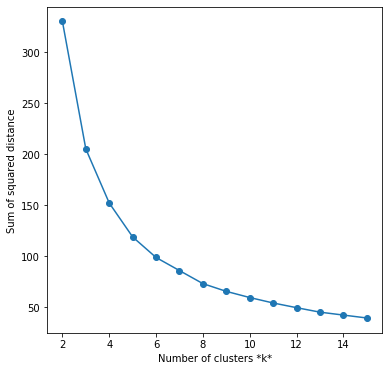

In [0]:
##Elbow method
sse = []
num_of_k = list(range(2, 16))

for k in num_of_k:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

### Performing Clustering and Assigning cluster id to each document

Once we get cluster id from K-means, it has been assigned to respective documents, in the original dataframe.

In [0]:
#performing clustering using Kmean classifier on features and obtaining the cluster id
def cluster_data():
  y_pred = KMeans(n_clusters=8).fit_predict(featuresSVD)
  print("Shape of original features : ",features.shape)
  print("length of y_pred of k means cluster : ", len(y_pred))
  df["cluster_id"]=y_pred

cluster_date()
df

Shape of original features :  (46228, 101404)
length of y_pred of k means cluster :  46228


,headline,text,bip:topics,itemid,dc.date.published,XMLfilename,cluster_id
0,Canadian Occidental mounts rival Wascana bid.,canadian occidental petroleum ltd emerged tues...,C181,326914,1997-03-18,326914newsML,1
1,"Gruma, Maseca to receive syndicated loan - bank.",bank america launch three year million syndica...,C173,326915,1997-03-18,326915newsML,1
2,Too early to call Krupp bid hostile - Deutsche...,deutsche bank ag management board member rolf ...,C18,326916,1997-03-18,326916newsML,1
5,"FOCUS - Euro bourses fret over Wall St, electi...",european bourse fell tuesday even wall street ...,M11,326917,1997-03-18,326917newsML,6
11,"French stocks fall, Alcatel posts big gain.",french share closed lower tuesday second conse...,G152,326918,1997-03-18,326918newsML,6
...,...,...,...,...,...,...,...
156405,Bulgaria seeks advisers for sale of state firms.,bulgarian government seeking financial adviser...,C183,477877,1997-03-31,477877newsML,1
156406,INTERVIEW-Lion Teck Chiang sees net up 70 pct ...,property steel group lion teck chiang ltd part...,C152,477878,1997-03-31,477878newsML,1
156411,Indian shares plunge 8.6 pct on political crisis.,indian share plunged eight percent panicky tra...,M11,477882,1997-03-31,477882newsML,0
156412,"Singapore shares open weak, funds stay sidelined.",singapore share opened weaker monday fund mana...,M11,477883,1997-03-31,477883newsML,6


## Different classifier for each identified cluster
For each of identified clusters, Random Forest classifier has been used. 
In total, 8 clusters are identified and classifier is used on each of them. 

**Analysis :** Out of these clusters, most of the clusters are perfoeming good except for two clausters where the performance goes in range of 60% for all of these classifiers

In [0]:
#Random forest classifier using cross val technique
for n in df["cluster_id"].unique():
  print("\n\n===================== Cluster : "+str(n)+" ============================")
  y_test,pred = train_classfier('Random Forest',df.loc[df["cluster_id"]==n])
  rf_accuracy,rf_precision,rf_recall,svm_f1 = evaluate_classfier_quality(pred,y_test)




===================== Cluster : 6 ============================
----Random Forest----
feature size (9034, 32400)
cross-validation score: 0.6439187034638251
Accuracy: 0.6356
Precision: 0.6375
Recall: 0.6356
F1: 0.5803


===================== Cluster : 1 ============================
----Random Forest----
feature size (22493, 80499)
cross-validation score: 0.6089061511666657
Accuracy: 0.6180
Precision: 0.5921
Recall: 0.6180
F1: 0.5791


===================== Cluster : 0 ============================
----Random Forest----
feature size (5281, 20881)
cross-validation score: 0.6247576255618165
Accuracy: 0.6215
Precision: 0.6115
Recall: 0.6215
F1: 0.5978


===================== Cluster : 5 ============================
----Random Forest----
feature size (3263, 13952)
cross-validation score: 0.7877771822485974
Accuracy: 0.7906
Precision: 0.7653
Recall: 0.7906
F1: 0.7495


===================== Cluster : 7 ============================
----Random Forest----
feature size (2713, 11100)
cross-validat

## Evaluating the quality of clusters

We used elbow method to determine optimal number of clusters for k means algorithm. For same number of clusters, to determine the quality of clusters Silhouette's score has been used. 

**Silhoeutte's method**

To evaluate the quality of clusters, Silhoeuttes method has been used. 

In this step, clusters are generated using K-means algorithm and then, silhoeutte score is calculated for number of clusters = 8 which was identified in elbow result. The more the Silhoutte score is, better the cluster is. 
In our case, Silhoutte score was maximum for number of cluster = 8 and Silhouette score is 0.47 which is considerable. However, in our case Silhouettes score keeps on fluctuating with more number of clusters. 


In [0]:
#Silhoutte's score calculation
def check_cluster_quality():

  kmeans = KMeans (n_clusters=8)
  preds = kmeans.fit_predict(featuresSVD)
  centers = kmeans.cluster_centers_
  #calculating the Silhoeutte score for each number of clusters
  score = silhouette_score(featuresSVD, preds,metric='euclidean')
  print ("Silhouette score = ", score)

check_cluster_quality()


Silhouette score =  0.4721952351112363


## Feature extraction
Two methods for feature extraction has been used and the reference for this knowledge has been taken from "Text feature extraction based on deep learning: a review" research paper.
1. Autoencoder
2. CNN

### i) Autoencoder

Since we were having, 101404 features, it becomes a necessity to choose the best features and restrict number of features. 
We have tried stacked Autoencoder, which is accuracy of 99.8% when decoding the output and comparing it to input provided. Hence we can say that, compressed data from autoencoder represents the input in best possible way. 

We have used three dense encoded and decoded layers and activation function is relu. We have used batch size of 256 to increase training speed and binary cross entropy loss function has been used.


In [0]:
arrAEFeatures = []

def build_AE(X_train,X_test):
    input_data = Input(shape=(X_train.shape[1],))
    
    encoded = Sequential()
    #Encoder
    encoded = Dense(256, activation='relu',name="encode_layer1")(input_data)
    encoded = Dense(128, activation='relu',name="encode_layer2")(encoded)
    encoded = Dense(64, activation='relu',name="encode_layer3")(encoded)

    #Decoder
    decoded = Dense(128, activation='relu',name="decode_layer1")(encoded)
    decoded = Dense(256, activation='relu',name="decode_layer2")(decoded)
    decoded = Dense(X_train.shape[1], activation='sigmoid',name="decode_layer3")(decoded)

    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer='adadelta',metrics=['accuracy'], loss='binary_crossentropy')
    autoencoder.summary()
    return autoencoder

def run_autoEncoder():
    #extract features from each cluster and store in array
    for n in df["cluster_id"].unique():
        dictClusterFeatures = {}

        #get dataframe of current cluster
        currentDf = df.loc[df["cluster_id"]==n]

        #get data in tfidf vectorized form
        newDf,X = generate_features_and_labels(currentDf)
        Y = newDf["labels"]
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
      
        autoencoder = build_AE(X_train,X_test)
        autoencoder.fit(X_train, X_train,epochs=5,batch_size=256,validation_data=(X_test, X_test))
        
        #extract feautures from intermediate layer
        middle_layer = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer('encode_layer3').output)
        extractedFeatures = middle_layer.predict(X_train)
        
        #insert extracted feautes in dictionery
        dictClusterFeatures["cluster_id"] = n
        dictClusterFeatures["features"] = extractedFeatures
        dictClusterFeatures["target"] = y_train
        arrAEFeatures.append(dictClusterFeatures)

In [0]:
run_autoEncoder()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 59517)             0         
_________________________________________________________________
encode_layer1 (Dense)        (None, 256)               15236608  
_________________________________________________________________
encode_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
encode_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
decode_layer1 (Dense)        (None, 128)               8320      
_________________________________________________________________
decode_layer2 (Dense)        (None, 256)               33024     
__________________________

### ii) CNN for feature extraction (Extra work)
We tried to implement CNN for feature extraction but it failed because of few errors

We can take advantage of convolutional layer to find the pattern in text corpus. We have used total of 4 convolution layers with dropout layer to drop the fraction of 0.5 to escape from overfitting. This layer is essentially important because we are extracting features having more importance and regularizing the model. 

Word embedding:
This layer has been used as the first layer of model.

Glove has been used to generate word embedding for our features and it works best with CNN. 


In [0]:
arrCNNFeatures = []
#this function tokenize corpus and specify indexes of words
def tokenize_data(X_train, X_test):
    train_test = np.concatenate((X_train, X_test), axis=0)
    arrTrainText = np.array(train_test)
    ObjTokenizer = Tokenizer(num_words=75000)
    ObjTokenizer.fit_on_texts(arrTrainText)
    seq = ObjTokenizer.texts_to_sequences(arrTrainText)
    w_index = ObjTokenizer.word_index
    seqText = pad_sequences(seq, maxlen=500)
    ind = np.arange(seqText.shape[0])
    lenX = len(X_train)
    textInstance = seqText[ind]
    X_train = textInstance[0:lenX, ]
    X_test = textInstance[lenX:, ]
    return X_train,X_test,w_index

#this function fetch embedding from glove list
def get_glove_embedding():
    index_embedding = {}
    file = open("drive/My Drive/data/MLBD_Project/glove.6B.50d.txt", encoding="utf8")
    for line in file:
        arrWords = line.split()
        word = arrWords[0]
        try:
            coff = np.asarray(arrWords[1:], dtype='float32')
        except:
            pass
        index_embedding[word] = coff
    file.close()
    return index_embedding

#build convolutional neural network 
def build_CNN(w_index, index_embedding, num_of_classes):
    convolutions = []
    seqInput = Input(shape=(500,), dtype='int32')
    cnn = Sequential()
    lenWordIndex = len(w_index) + 1
    arrEmbedding = np.random.random((len(w_index) + 1, 50))
    for word, i in w_index.items():
        vector = index_embedding.get(word)
        if vector is not None:
            if len(arrEmbedding[i]) !=len(vector):
                exit(1)
            arrEmbedding[i] = vector
    layerEmbedding = Embedding(lenWordIndex,50,weights=[arrEmbedding],input_length=500,trainable=True)
    seqEmbedding = layerEmbedding(seqInput)

    for ks in [5,6]:
        conv = Conv1D(128, activation='relu',kernel_size=ks)(seqEmbedding)
        pool = MaxPooling1D(5)(conv)
        convolutions.append(pool)

    mergeConv = Concatenate(axis=1)(convolutions)
    conv = Conv1D(128, 5, activation='relu')(mergeConv)
    conv = Dropout(0.5)(conv)
    pool = MaxPooling1D(5)(conv)
    conv2 = Conv1D(128, 5, activation='relu')(pool)
    conv2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(30)(conv2)
    flat = Flatten()(pool2)
    dense = Dense(1024, activation='relu')(flat)
    dense = Dropout(0.5)(dense)
    dense = Dense(512, activation='relu',name="feature_layer")(dense)
    dense = Dropout(0.5)(dense)
    prediction = Dense(num_of_classes, activation='softmax')(dense)
    cnn = Model(seqInput, prediction)
    cnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return cnn


def extract_feautres_cnn():
  
  for n in df["cluster_id"].unique():
    dictClusterFeatures = {}

    #get dataframe of current cluster
    currentDf = df.loc[df["cluster_id"]==n]
    #passing features of each and every cluster to neural network
    print("\n\Extracting features from convolutional neural network")
    

    classes = currentDf["bip:topics"].unique().tolist()
    #encode classes to numeric values
    target = currentDf["bip:topics"].apply(classes.index)
    

    X_train, X_test, y_train, y_test = train_test_split(currentDf["text"],target,test_size=0.3,random_state=42)
    X_train_new,X_test_new,word_index = tokenize_data(X_train,X_test)
    embeddings_index = get_glove_embedding()
    cnn = build_CNN(word_index,embeddings_index, len(target.unique()))

    cnn.summary()

    cnn.fit(X_train_new, y_train,validation_data=(X_test_new, y_test),epochs=10,batch_size=256,verbose=2)

    predicted = cnn.predict(X_train_new)

    predicted = np.argmax(predicted, axis=1)

    #extract feautures from intermediate layer
    middle_layer = Model(inputs=cnn.input,outputs=cnn.get_layer('feature_layer').output)
    extractedFeatures = middle_layer.predict(X_train)
        
    #insert extracted feautes in dictionery
    dictCNNFeatures["cluster_id"] = n
    dictCNNFeatures["features"] = extractedFeatures
    dictCNNFeatures["target"] = y_train
    arrAEFeatures.append(dictCNNFeatures)

    print(metrics.classification_report(y_train, predicted))


## Passing new features in deep neural networks

At this stage, features extracted from stacked autoencoder has been been used for Neural network training. Here we are using Sequential neural network to understand how new features extracted from stacked autoencoder improving the efficiency of classification. 
Since there are total of 8 clusters, one of the cluster is taken into consideration to represent the improved accuracy with Neural network and new extracted features.


**Before Feature Extraction**

Random Forest : average accuracy 70.25%
Classification was performed on all the clusters and above mentioned is the average accuracy. 

Accuracy of cluster 8 : 84%

**After feature extraction**

Sequential model: average accuacy 79.50%

Accuracy of cluster 8 : 93.6%


Hence it can be seen that classification has been improved with the new features. Moreover, it is important to notice that classifers Random Forest is trained using 101404 features in comparision to sequential model(trained on only one third of features) and giving better performance. 
With the use of NN,more meaningful features used for training the NN classifier and here, Autoencoder is giving significant results while extracting the features. Sequential model is using multiple layer to learn maximum from features in each cluster.




In [0]:
def build_deep_neural_network(shape, num_of_classes):
    nn = Sequential()
    nn.add(Dense(512,input_dim=shape,activation='relu'))
    nn.add(Dropout(0.5))
    nn.add(Dense(512,input_dim=512,activation='relu'))
    nn.add(Dropout(0.5))
    nn.add(Dense(512,input_dim=512,activation='relu'))
    nn.add(Dropout(0.5))
    nn.add(Dense(512,input_dim=512,activation='relu'))
    nn.add(Dropout(0.5))
    print("num_of_classes",num_of_classes)
    nn.add(Dense(num_of_classes+num_of_classes, activation='softmax'))
    nn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return nn

def run_deep_neural_network():
  #passing features of each and every cluster to neural network
  for dictFeatures in arrAEFeatures:
    print("\n\nTraining neural network for Cluster id: "+str(dictFeatures["cluster_id"]))
    target = dictFeatures["target"]
    classes = target.unique().tolist()
    #encode classes to numeric values
    target = dictFeatures["target"].apply(classes.index)
    features = dictFeatures["features"]

    X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3,random_state=42)
    nn = build_deep_neural_network(X_train.shape[1],len(y_train.unique())+1)
    nn.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=10,batch_size=128,verbose=2)
    predicted = nn.predict(X_test)
    predicted = np.argmax(predicted, axis=1)
    accuracy,precision,recall,f1 = evaluate_classfier_quality(predicted,y_test)


In [0]:
run_deep_neural_network()



Training neural network for Cluster id: 1

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
num_of_classes 47
Train on 10761 samples, validate on 4612 samples
Epoch 1/10
 - 4s - loss: 3.1495 - acc: 0.1893 - val_loss: 2.8451 - val_acc: 0.2214
Epoch 2/10
 - 3s - loss: 2.8961 - acc: 0.2120 - val_loss: 2.8366 - val_acc: 0.2214
Epoch 3/10
 - 3s - loss: 2.8801 - acc: 0.2142 - val_loss: 2.8329 - val_acc: 0.2214
Epoch 4/10
 - 3s - loss: 2.8751 - acc: 0.2146 - val_loss: 2.8306 - val_acc: 0.2214
Epoch 5/10
 - 3s - loss: 2.8663 - acc: 0.2143 - val_loss: 2.8446 - val_acc: 0.2214
Epoch 6/10
 - 3s - loss: 2.8661 - acc: 0.2143 - val_loss: 2.8230 - val_acc: 0.2214
Epoch 7/10
 - 3s - loss: 2.8567 - acc: 0.2145 - val_loss: 2.8341 - val_acc: 0.2214
Epoch 8/10
 - 3s - loss: 2.8543 - acc: 0.2145 - val_loss: 2.8172 - val_acc: 0.2214
Epoch 9/10
 - 3s - loss: 2.8516 - acc: 0.2145 - val_loss: 2.8180 - val_acc: 0.2214
Epoch 10/10
 - 3s - loss: 

## References

[1] I. Dabbura, “K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks,” Medium, 03-Sep-2019. [Online]. Available: https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a.

[2] kk7nc, “kk7nc/Text_Classification,” GitHub, 05-Dec-2019. [Online]. Available: https://github.com/kk7nc/Text_Classification#autoencoder.

[3] F. Chollet, “The Keras Blog,” The Keras Blog ATOM. [Online]. Available: https://blog.keras.io/building-autoencoders-in-keras.html.

[4] Liang, Hong et al. “Text feature extraction based on deep learning: a review.” EURASIP journal on wireless communications and networking vol. 2017,1 (2017): 211. doi:10.1186/s13638-017-0993-1

[5] Maggipinto, M., Masiero, C., Beghi, A., & Susto, G. A. (2018). A Convolutional Autoencoder Approach for Feature Extraction in Virtual Metrology: Paper ID 259. Procedia Manufacturing, 17, 126-133.


## Acknowledging Help from TA

We would like to thank Mohammad Etemad for his feedback and support in this project.  